In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy
import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from plotly.subplots import make_subplots
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency, ttest_ind
from sklearn import set_config
set_config(transform_output="pandas")

In [90]:
# Reading the dataset
file_path = 'HeartDisease/heart_disease_full.csv'
df = pd.read_csv(file_path)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_encoded,ever_married_encoded,work_type_encoded,Residence_type_encoded,smoking_status_encoded,Age_temp,avg_glucose_level_temp
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,1,1,2,1,1,1,2
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.75,never smoked,1,0,1,3,0,2,1,2
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,1,1,2,0,2,1,2
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,0,1,2,1,3,0,2
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,0,1,3,0,2,1,2


In [91]:
df['hypertension_stroke_risk'] = (df['hypertension'] | df['stroke']).astype(int)

In [92]:
# categorical = ['gender', 'ever_married', 'work_type', 
#                'Residence_type', 'smoking_status', 'hypertension', 
#                'heart_disease', 'stroke']
# numerical = ['age', 'avg_glucose_level', 'bmi']

In [93]:
categorical = ['gender', 'ever_married', 'work_type', 
               'Residence_type', 'smoking_status', 'hypertension_stroke_risk', 'heart_disease']
numerical = ['age', 'avg_glucose_level', 'bmi']

In [94]:
results = {}
for var in categorical:
    contingency_table = pd.crosstab(df[var], df["heart_disease"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results[var] = {"Chi2": chi2, "p-value": p, "Association": "Yes" if p <= 0.05 else "No"}

# Convert results to DataFrame
chi_square_results = pd.DataFrame(results).T
print(chi_square_results)

                                 Chi2   p-value Association
gender                      41.668182       0.0         Yes
ever_married                 0.289938   0.59026          No
work_type                    12.54881  0.001884         Yes
Residence_type                    0.0       1.0          No
smoking_status              12.276205  0.006494         Yes
hypertension_stroke_risk     59.51801       0.0         Yes
heart_disease             3589.825902       0.0         Yes


Chi-Square test of Independence measures if there is a significant relationship between two categorical variables. It measures how a model compares to actual observed data. 

Interpret the p-value:  

If p <= 0.05, reject the null hypothesis (There is no relationship) (i.e., the variables are associated).  

If p > 0.05, fail to reject the null hypothesis (There is relationship) (i.e., no significant association).

The results above indicate that **heart disease** has no relationship with **ever_married**, and **residence type**. So, we will remove these predictors from the model building. 

Standardizing numerical variables to use them to run the t-test.

In [95]:
# Standardizing only numerical variables
df[numerical] = StandardScaler().fit_transform(df[numerical])
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_encoded,ever_married_encoded,work_type_encoded,Residence_type_encoded,smoking_status_encoded,Age_temp,avg_glucose_level_temp,hypertension_stroke_risk
0,Male,0.827396,0,1,Yes,Private,Urban,2.372734,0.922159,formerly smoked,1,1,1,2,1,1,1,2,1
1,Female,0.434303,0,0,Yes,Self-employed,Rural,1.838818,-0.310227,never smoked,1,0,1,3,0,2,1,2,1
2,Male,1.679096,0,1,Yes,Private,Rural,-0.102676,0.278493,never smoked,1,1,1,2,0,2,1,2,1


In [96]:
numerical = list(df[numerical].columns)

# T-Test for each numerical variable
results = {}
for var in numerical:
    group1 = df[df["heart_disease"] == 0][var]  # No Stroke
    group2 = df[df["heart_disease"] == 1][var]  # Stroke
    
    t_stat, p_value = ttest_ind(group1, group2)
    
    results[var] = {"T-Statistic": t_stat, "p-value": p_value, "Significant": "Yes" if p_value <= 0.05 else "No"}

# Convert results to DataFrame
t_test_results = pd.DataFrame(results).T
print(t_test_results)

                  T-Statistic   p-value Significant
age                 -16.47509       0.0         Yes
avg_glucose_level   -9.174475       0.0         Yes
bmi                  1.356531  0.175015          No


T-test compares the means of the numerical predictor between the two categories. In our case we are checking if age differs significantly between stroke vs. no stroke.  

The results show that **age**, and **average glucose level** are significantly different between stroke and non-stroke patients. However, there is no significant difference in means of **bmi** between No stroke and Stroke patients. So, we'll drop bmi.

In [97]:
df = df[['gender_encoded', 'work_type_encoded', 'smoking_status_encoded', 'age', 'avg_glucose_level',  'hypertension_stroke_risk', 'heart_disease']]
df.head(3)

,gender_encoded,work_type_encoded,smoking_status_encoded,age,avg_glucose_level,hypertension_stroke_risk,heart_disease
0,1,2,1,0.827396,2.372734,1,1
1,0,3,2,0.434303,1.838818,1,0
2,1,2,2,1.679096,-0.102676,1,1


## Logistic Regression to predict Stroke

In [98]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df['heart_disease'], test_size=0.20, random_state=42)

## Class Imbalance

The classification report is: 
               precision    recall  f1-score   support

           1       0.50      0.02      0.03        62

   micro avg       0.50      0.02      0.03        62
   macro avg       0.50      0.02      0.03        62
weighted avg       0.50      0.02      0.03        62




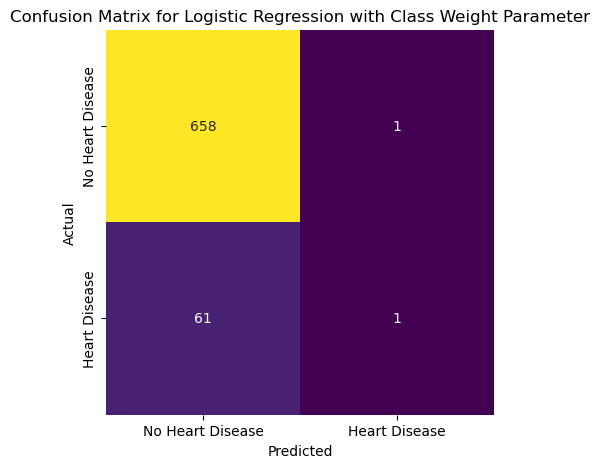

In [99]:
log_reg = LogisticRegression(random_state=42)

# Fit the model
log_reg.fit(x_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(x_test)

# Evaluate the model by focusing on 'label = 1' (positive class)
report_log_reg = classification_report(y_test, y_pred_log_reg, labels = [1])
print(f"The classification report is: \n {report_log_reg}\n")

conf_matrix = confusion_matrix(y_test, y_pred_log_reg)

plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with Class Weight Parameter')
plt.show()

## Handling Class Imbalance using class_weight parameter

The classification report is: 
               precision    recall  f1-score   support

           1       0.21      0.84      0.33        62

   micro avg       0.21      0.84      0.33        62
   macro avg       0.21      0.84      0.33        62
weighted avg       0.21      0.84      0.33        62




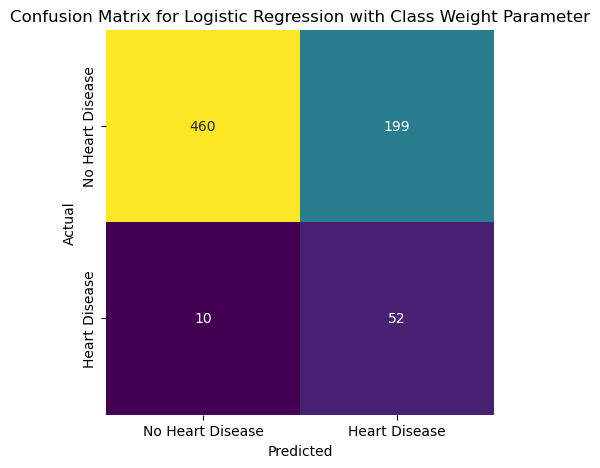

In [100]:
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# Fit the model
log_reg.fit(x_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(x_test)

# Evaluate the model by focusing on 'label = 1' (positive class)
report_log_reg = classification_report(y_test, y_pred_log_reg, labels = [1])
print(f"The classification report is: \n {report_log_reg}\n")

conf_matrix = confusion_matrix(y_test, y_pred_log_reg)

plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with Class Weight Parameter')
plt.show()

## Hyperparameter Tuning

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'class_weight': {0: 1, 1: 5}, 'max_iter': 100}
The classification report is: 
              precision    recall  f1-score   support

           1       0.29      0.52      0.37        62

   micro avg       0.29      0.52      0.37        62
   macro avg       0.29      0.52      0.37        62
weighted avg       0.29      0.52      0.37        62



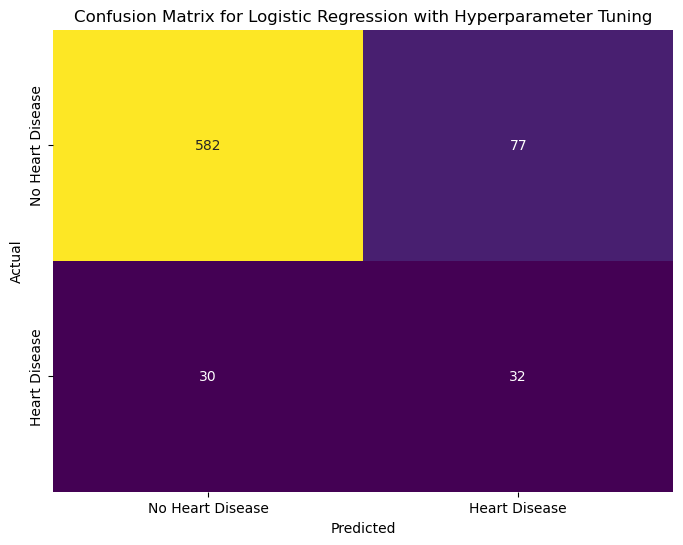

In [101]:
log_reg = LogisticRegression(random_state=42)

# Define the parameter grid for class_weight and max_iter
param_grid = {
    'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 50}, {0: 1, 1: 100}, {0: 1, 1: 500}, {0: 1, 1: 1000}],
    'max_iter': [100, 200, 500, 1000]  # Range of max_iter values
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the GridSearchCV
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Get the best model from GridSearchCV
best_log_reg = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred_log_reg = best_log_reg.predict(x_test)

# Evaluate the model using classification report
report_log_reg = classification_report(y_test, y_pred_log_reg, labels=[1])
print(f"The classification report is: \n{report_log_reg}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_log_reg)

# Plot confusion matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, 
            xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'], ax=ax)

# Customize labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with Hyperparameter Tuning')

# Show the plot
plt.show()

SMOTE

Before SMOTE:

heart_disease
0    2670
1     213
Name: count, dtype: int64

After SMOTE:

heart_disease
0    2670
1    2670
Name: count, dtype: int64

The classification report is: 
               precision    recall  f1-score   support

           1       0.20      0.81      0.32        62

   micro avg       0.20      0.81      0.32        62
   macro avg       0.20      0.81      0.32        62
weighted avg       0.20      0.81      0.32        62




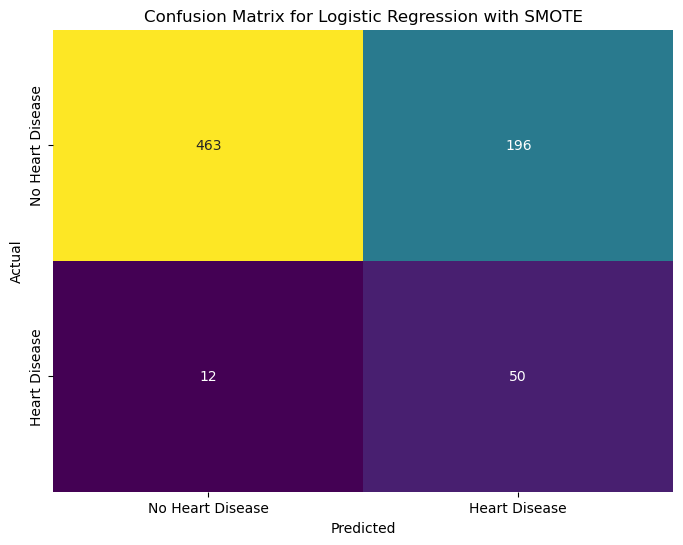

In [102]:
smote = SMOTE(random_state=42)

x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Check the new class distribution after SMOTE
print("Before SMOTE:\n")
print(f"{y_train.value_counts()}\n")
print("After SMOTE:\n")
print(f"{y_train_smote.value_counts()}\n")

# Instantiate the Logistic Regression model without class_weight
log_reg = LogisticRegression(random_state=42)

# Fit the model using the SMOTE-resampled training data
log_reg.fit(x_train_smote, y_train_smote)

# Predict on the test set
y_pred_log_reg = log_reg.predict(x_test)

# Evaluate the model by focusing on 'label = 1' (positive class)
report_log_reg = classification_report(y_test, y_pred_log_reg, labels = [1])
print(f"The classification report is: \n {report_log_reg}\n")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_log_reg)

# Plot confusion matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'], ax=ax)

# Customize labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with SMOTE')

# Show the plot
plt.show()

## Decision Tree

Classification Report:
              precision    recall  f1-score   support

           1       0.07      0.06      0.07        62

   micro avg       0.07      0.06      0.07        62
   macro avg       0.07      0.06      0.07        62
weighted avg       0.07      0.06      0.07        62



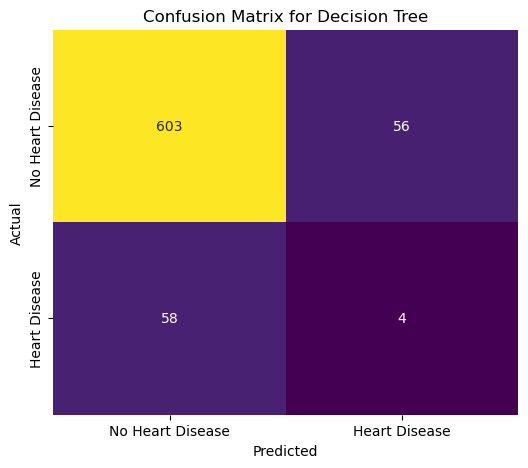

In [103]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the Decision Tree model on the training data
dt.fit(x_train, y_train)

# Predict on the test set
y_pred_dt = dt.predict(x_test)

# Evaluate the model using classification report
report_dt = classification_report(y_test, y_pred_dt, labels=[1])
print(f"Classification Report:\n{report_dt}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, 
            xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

## Random Forest with class weight

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.08      0.14        62

   micro avg       0.50      0.08      0.14        62
   macro avg       0.50      0.08      0.14        62
weighted avg       0.50      0.08      0.14        62



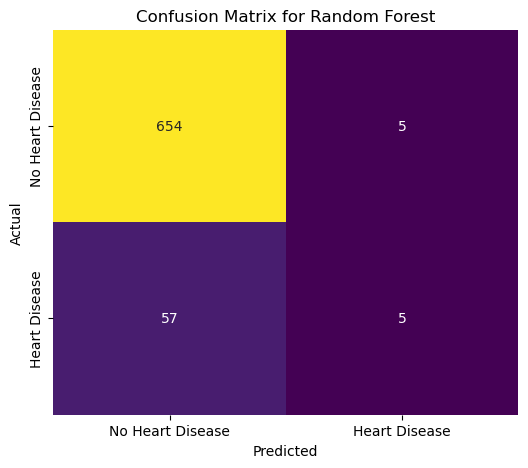

In [104]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(x_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(x_test)

# Evaluate the model
report_rf = classification_report(y_test, y_pred_rf, labels=[1])
print(f"Classification Report:\n{report_rf}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

## Random Forest with SMOTE

Before SMOTE:
heart_disease
0    2670
1     213
Name: count, dtype: int64

After SMOTE:
heart_disease
0    2670
1    2670
Name: count, dtype: int64

Classification Report:
               precision    recall  f1-score   support

           1       0.19      0.32      0.24        62

   micro avg       0.19      0.32      0.24        62
   macro avg       0.19      0.32      0.24        62
weighted avg       0.19      0.32      0.24        62



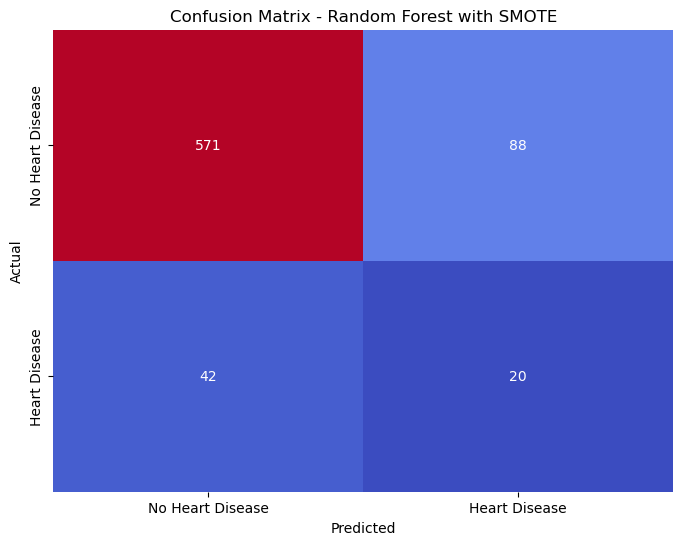

In [105]:
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Check class distribution before and after SMOTE
print(f"Before SMOTE:\n{y_train.value_counts()}\n")
print(f"After SMOTE:\n{y_train_smote.value_counts()}\n")

# Train Random Forest on SMOTE-resampled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(x_train_smote, y_train_smote)

# Predict on the test set
y_pred_rf = rf_model.predict(x_test)

# Classification report focusing on label 1
print("Classification Report:\n", classification_report(y_test, y_pred_rf, labels=[1]))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False, 
            xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest with SMOTE')

# Show the plot
plt.show()